Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [149]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [218]:
# IMPORTS
from category_encoders import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [151]:
# DATA WRANGLING

def readin(f_path):
    # Read in NYC property sales data, apply instructor filtering, return df
    df = pd.read_csv(DATA_PATH+f_path)

    # Change column names: replace spaces with underscores
    df.columns = [col.replace(' ', '_') for col in df]

    # SALE_PRICE was read as strings.
    # Remove symbols, convert to integer
    df['SALE_PRICE'] = (
        df['SALE_PRICE']
        .str.replace('$','')
        .str.replace('-','')
        .str.replace(',','')
        .astype(int)
    )

    # BOROUGH is a numeric column, but arguably should be a categorical feature,
    # so convert it from a number to a string
    df['BOROUGH'] = df['BOROUGH'].astype(str)

    ## Reduce cardinality for NEIGHBORHOOD feature
    # Get a list of the top 10 neighborhoods
    top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

    # At locations where the neighborhood is NOT in the top 10, 
    # replace the neighborhood with 'OTHER'
    df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

    return df

def wrangle(filepath):
    # Send to readin for data read-in and initial filtering
    df = readin(filepath)

    # Filter df for one-family dwellings with sales price > $100K and < 2M
    df = df.loc[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & 
                (df['SALE_PRICE'] > 100_000) &
                (df['SALE_PRICE'] < 2_000_000)]

    # EASE-MENT and APARTMENT_NUMBERS have a single non null value, will drop cols
    df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)

    # Drop BUILDING_CLASS_CATEGORY and TAX_CLASS_AT_TIME_OF_SALE since they are
    # both populated with only a single value for every observation
    df.drop(labels=['BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_TIME_OF_SALE'], axis=1, inplace=True)

    # Convert LAND_SQUARE_FEET to an integer from string
    df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(",", '').astype(int)

    # Convert GROSS_SQUARE_FEET and YEAR_BUILT to integers
    df['GROSS_SQUARE_FEET'] = df['GROSS_SQUARE_FEET'].astype(int)
    df['YEAR_BUILT'] = df['YEAR_BUILT'].astype(int)

    ## Make ZIP_CODE a categorical feature
    # Convert ZIP_CODE to str
    df['ZIP_CODE'] = df['ZIP_CODE'].astype(int).astype(str)
    top10 = df['ZIP_CODE'].value_counts()[:10].index

    # At locations where the zip code is NOT in the top 10, 
    # replace zip code with 'OTHER'
    df.loc[~df['ZIP_CODE'].isin(top10), 'ZIP_CODE'] = 'OTHER'

    # Drop ADDRESS - high cardinality identifier
    df.drop(columns=['ADDRESS'], inplace=True)

    # Convert SALE_DATE to a datetime object and set as DataFrame index
    df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
    df.set_index(keys='SALE_DATE', inplace=True)
    df.sort_index(inplace=True)

    return df

in_file = 'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

price_df = wrangle(in_file)

print(price_df.shape)
price_df.head()

(3151, 15)


,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
SALE_DATE,,,,,,,,,,,,,,,
2019-01-01,3,OTHER,1,5495,801,A9,OTHER,1.0,0.0,1.0,6800,1325,1930,A9,550000
2019-01-01,4,OTHER,1,7918,72,A1,OTHER,1.0,0.0,1.0,4000,2001,1940,A1,200000
2019-01-02,2,OTHER,1,4210,19,A1,OTHER,1.0,0.0,1.0,3500,2043,1925,A1,810000
2019-01-02,3,OTHER,1,5212,69,A1,OTHER,1.0,0.0,1.0,4000,2680,1899,A1,125000
2019-01-02,3,OTHER,1,7930,121,A5,OTHER,1.0,0.0,1.0,1710,1872,1940,A5,620000


In [152]:
price_df['SALE_PRICE'].describe()

count    3.151000e+03
mean     6.285601e+05
std      2.929904e+05
min      1.040000e+05
25%      4.475000e+05
50%      5.680000e+05
75%      7.600000e+05
max      1.955000e+06
Name: SALE_PRICE, dtype: float64

In [153]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3151 entries, 2019-01-01 to 2019-04-30
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         3151 non-null   object 
 1   NEIGHBORHOOD                    3151 non-null   object 
 2   TAX_CLASS_AT_PRESENT            3151 non-null   object 
 3   BLOCK                           3151 non-null   int64  
 4   LOT                             3151 non-null   int64  
 5   BUILDING_CLASS_AT_PRESENT       3151 non-null   object 
 6   ZIP_CODE                        3151 non-null   object 
 7   RESIDENTIAL_UNITS               3151 non-null   float64
 8   COMMERCIAL_UNITS                3151 non-null   float64
 9   TOTAL_UNITS                     3151 non-null   float64
 10  LAND_SQUARE_FEET                3151 non-null   int64  
 11  GROSS_SQUARE_FEET               3151 non-null   int64  
 12  YEAR_BUILT      

In [154]:
price_df.nunique()


BOROUGH                              5
NEIGHBORHOOD                         7
TAX_CLASS_AT_PRESENT                 2
BLOCK                             2496
LOT                                332
BUILDING_CLASS_AT_PRESENT           13
ZIP_CODE                            11
RESIDENTIAL_UNITS                    3
COMMERCIAL_UNITS                     3
TOTAL_UNITS                          4
LAND_SQUARE_FEET                  1035
GROSS_SQUARE_FEET                 1050
YEAR_BUILT                          89
BUILDING_CLASS_AT_TIME_OF_SALE      11
SALE_PRICE                        1000
dtype: int64

<AxesSubplot:xlabel='SALE_PRICE', ylabel='Density'>

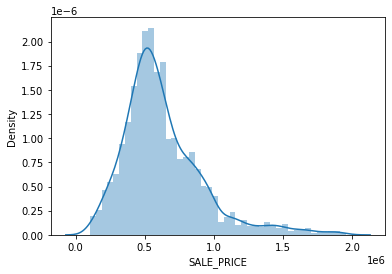

In [252]:
sns.distplot(price_df['SALE_PRICE'])

<AxesSubplot:xlabel='LAND_SQUARE_FEET', ylabel='Density'>

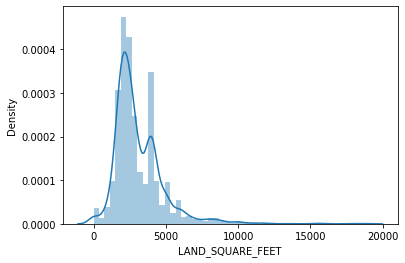

In [250]:
sns.distplot(price_df['LAND_SQUARE_FEET'])

<AxesSubplot:xlabel='GROSS_SQUARE_FEET', ylabel='Density'>

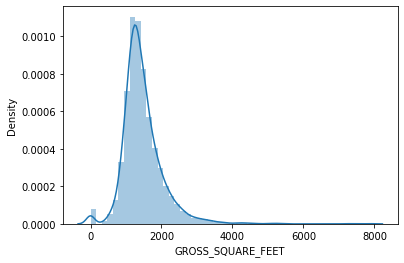

In [251]:
sns.distplot(price_df['GROSS_SQUARE_FEET'])

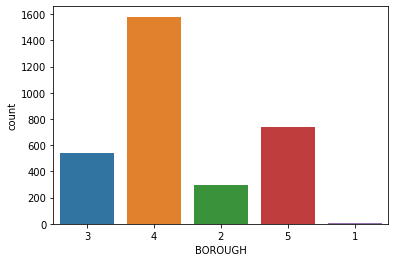

In [263]:
sns.countplot(price_df['BOROUGH']);

In [155]:
# SPLIT THE DATA
# Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

target = 'SALE_PRICE'

y = price_df[target]
X = price_df.drop(columns=target)

print(X.shape, y.shape)

(3151, 14) (3151,)


In [156]:
mask = X.index < '2019-04-01'

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

display(X_train.tail())
display(X_test.head())

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE
SALE_DATE,,,,,,,,,,,,,,
2019-03-29,5,OTHER,1,4081,44,A2,10306,1.0,0.0,1.0,2400,921,1950,A2
2019-03-29,5,OTHER,1,2373,201,A5,10314,1.0,0.0,1.0,2450,2128,1980,A5
2019-03-29,5,OTHER,1,1132,42,A1,OTHER,1.0,0.0,1.0,4361,1807,2018,A1
2019-03-29,5,OTHER,1,3395,37,A2,10305,1.0,0.0,1.0,6000,621,1930,A2
2019-03-30,4,OTHER,1,11159,11,A0,OTHER,1.0,0.0,1.0,3910,1163,1950,A0


,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE
SALE_DATE,,,,,,,,,,,,,,
2019-04-01,2,OTHER,1,5913,878,A1,OTHER,1.0,0.0,1.0,5000,2272,1930,A1
2019-04-01,2,OTHER,1,5488,48,A2,OTHER,1.0,0.0,1.0,2500,720,1935,A2
2019-04-01,3,OTHER,1,5936,31,A1,OTHER,1.0,0.0,1.0,2880,2210,1925,A1
2019-04-01,3,OTHER,1,7813,24,A5,OTHER,1.0,0.0,1.0,1305,1520,1915,A5
2019-04-01,3,OTHER,1,8831,160,A9,11229,1.0,0.0,1.0,1800,840,1925,A9


In [157]:
# ESTABLISH A NAIVE BASELINE
# Mean baseline

guess = y_train.mean()
print('Mean baseline (0 features): {:,.2f}'.format(guess))

Mean baseline (0 features): 621,573.74


In [158]:
# Basline MAE, RMSE and R^2

y_pred = [guess] * len(y_train)

mae = mean_absolute_error(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred, squared=False)
r2 = r2_score(y_train, y_pred)

print(f'Basline MAE: {mae:,.2f}')
print(f'Basline RMSE: {rmse:,.2f}')
print(f'Baseline R2: {r2:.2f}')

Basline MAE: 214,721.53
Basline RMSE: 291,549.06
Baseline R2: 0.00


In [159]:
# PERFORM ONE HOT ENCODING OF CATEGORICAL FEATURES
# Instantiate the transformer
ohe = OneHotEncoder(use_cat_names=True)

# Fit transformer on training data
ohe.fit(X_train) # Never refit data on test data

# Transform data with transormer
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

In [125]:
XT_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 2019-01-01 to 2019-03-30
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   BOROUGH_3                          2507 non-null   int64  
 1   BOROUGH_4                          2507 non-null   int64  
 2   BOROUGH_2                          2507 non-null   int64  
 3   BOROUGH_5                          2507 non-null   int64  
 4   BOROUGH_1                          2507 non-null   int64  
 5   NEIGHBORHOOD_OTHER                 2507 non-null   int64  
 6   NEIGHBORHOOD_FLUSHING-NORTH        2507 non-null   int64  
 7   NEIGHBORHOOD_EAST NEW YORK         2507 non-null   int64  
 8   NEIGHBORHOOD_BEDFORD STUYVESANT    2507 non-null   int64  
 9   NEIGHBORHOOD_FOREST HILLS          2507 non-null   int64  
 10  NEIGHBORHOOD_BOROUGH PARK          2507 non-null   int64  
 11  NEIGHBORHOOD_ASTORIA               250

In [145]:
# COMPLETE FEATURE SELECTION WITH SELECTKBEST
# Looks best for LR at about 13 features 

for k in range(1, len(XT_train.columns)+1):
    print(f'Number of feature(s): {k} \n')

    skb = SelectKBest(score_func=f_regression, k=k)
    XTT_train = skb.fit_transform(XT_train, y_train)
    XTT_test = skb.transform(XT_test)

    model_lr = LinearRegression()
    model_lr.fit(XTT_train, y_train)
    mae_train = mean_absolute_error(y_train, model_lr.predict(XTT_train))
    mae_test = mean_absolute_error(y_test, model_lr.predict(XTT_test))
    print(f'Training MAE using LR: {mae_train:,.2f}') 
    print(f'Test MAE using LR: {mae_test:,.2f}')
    print('_________________________________\n\n')





Number of feature(s): 1 

Training MAE using LR: 193,398.05
Test MAE using LR: 183,640.59
_________________________________


Number of feature(s): 2 

Training MAE using LR: 190,487.64
Test MAE using LR: 179,554.77
_________________________________


Number of feature(s): 3 

Training MAE using LR: 189,889.85
Test MAE using LR: 179,291.47
_________________________________


Number of feature(s): 4 

Training MAE using LR: 189,889.85
Test MAE using LR: 179,291.47
_________________________________


Number of feature(s): 5 

Training MAE using LR: 182,256.92
Test MAE using LR: 178,896.91
_________________________________


Number of feature(s): 6 

Training MAE using LR: 175,271.09
Test MAE using LR: 173,139.12
_________________________________


Number of feature(s): 7 

Training MAE using LR: 174,104.26
Test MAE using LR: 171,681.95
_________________________________


Number of feature(s): 8 

Training MAE using LR: 173,498.94
Test MAE using LR: 169,111.48
____________________________

In [162]:
# Linear Regression outcome using SelectKBset
# Better performance than the baseline, not so great R^2 score

skb = SelectKBest(score_func=f_regression, k=13)
XTT_train = skb.fit_transform(XT_train, y_train)
XTT_test = skb.transform(XT_test)

model_lr = LinearRegression()
model_lr.fit(XTT_train, y_train)
mae_train = mean_absolute_error(y_train, model_lr.predict(XTT_train))
mae_test = mean_absolute_error(y_test, model_lr.predict(XTT_test))
rmse_test = mean_squared_error(y_test, model_lr.predict(XTT_test), squared=False)
r2 = r2_score(y_test, model_lr.predict(XTT_test))
print(f'Training MAE using LR with Select-K-Best: {mae_train:,.2f}') 
print(f'Test MAE using LR with Select-K-Best: {mae_test:,.2f}')
print(f'Test RMSE using LR with Select-K-Best: {rmse_test:,.2f}')
print(f'Test R-squared score: {r2:.2f}')

Training MAE using LR with Select-K-Best: 155,762.29
Test MAE using LR with Select-K-Best: 155,998.78
Test RMSE using LR with Select-K-Best: 226,672.36
Test R-squared score: 0.42


In [190]:
# Let's look at the Linear Regression feature importances, using SKB

mask = skb.get_support()
columns = XT_train.columns
feature_names = []

for _ in range(len(XT_train.columns)):
    if mask[_] == True:
        feature_names.append(columns[_])

coefficients = model_lr.coef_

feature_importances = pd.Series(coefficients, index=feature_names).sort_values(key=abs)
feature_importances

# selected_mask = selector.get_support()
# all_features = X_train.columns
# selected_feature = all_features[selected_mask]


BLOCK                                   -24.447795
LAND_SQUARE_FEET                         31.139714
GROSS_SQUARE_FEET                       167.961085
ZIP_CODE_OTHER                        20446.843863
BUILDING_CLASS_AT_TIME_OF_SALE_A3     51107.499497
BUILDING_CLASS_AT_PRESENT_A3          51107.499497
TOTAL_UNITS                          -61299.608665
BOROUGH_3                             94297.229353
NEIGHBORHOOD_OTHER                   129481.890403
NEIGHBORHOOD_FLUSHING-NORTH          253752.719456
BOROUGH_5                           -266804.275747
BOROUGH_2                           -276242.828418
NEIGHBORHOOD_FOREST HILLS            461375.267580
dtype: float64

<AxesSubplot:title={'center':'LR with SKB Coefficients'}>

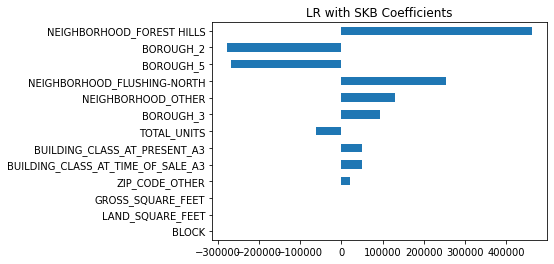

In [193]:
feature_importances.plot(kind='barh', title='LR with SKB Coefficients')

In [203]:
# Ridge Regression outcomes
# Best threshold appears to be 0.01

for alpha in [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 10]:
    print(f'Alpha level: {alpha} \n')
    model_ridge = Ridge(alpha=alpha, normalize=True)
    model_ridge.fit(XT_train, y_train)
    mae_train = mean_absolute_error(y_train, model_ridge.predict(XT_train))
    mae_test = mean_absolute_error(y_test, model_ridge.predict(XT_test))
    print(f'Training MAE using Ridge: {mae_train:,.2f}')
    print(f'Test MAE using Ridge: {mae_test:,.2f}')
    print('____________________________________\n\n')




Alpha level: 0.001 

Training MAE using Ridge: 144,959.44
Test MAE using Ridge: 153,402.61
____________________________________


Alpha level: 0.01 

Training MAE using Ridge: 144,950.90
Test MAE using Ridge: 153,113.63
____________________________________


Alpha level: 0.1 

Training MAE using Ridge: 146,158.93
Test MAE using Ridge: 153,182.15
____________________________________


Alpha level: 1 

Training MAE using Ridge: 164,367.17
Test MAE using Ridge: 166,695.30
____________________________________


Alpha level: 2 

Training MAE using Ridge: 175,733.81
Test MAE using Ridge: 176,649.55
____________________________________


Alpha level: 3 

Training MAE using Ridge: 182,689.37
Test MAE using Ridge: 182,757.45
____________________________________


Alpha level: 4 

Training MAE using Ridge: 187,407.91
Test MAE using Ridge: 186,959.66
____________________________________


Alpha level: 5 

Training MAE using Ridge: 190,894.03
Test MAE using Ridge: 190,078.85
______________________

In [208]:
model_ridge = Ridge(alpha=0.01, normalize=True)
model_ridge.fit(XT_train, y_train)
mae_train = mean_absolute_error(y_train, model_ridge.predict(XT_train))
mae_test = mean_absolute_error(y_test, model_ridge.predict(XT_test))
rmse_test = mean_squared_error(y_test, model_ridge.predict(XT_test), squared=False)
r2 = r2_score(y_test, model_ridge.predict(XT_test))

print(f'Training MAE using Ridge: {mae_train:,.2f}')
print(f'Test MAE using Ridge: {mae_test:,.2f}')
print(f'Test RMSE using Ridge: {rmse_test:,.2f}')
print(f'R-squared score: {r2:.2f}')
print('____________________________________\n\n')


""" Training MAE using LR with Select-K-Best: 155,762.29
Test MAE using LR with Select-K-Best: 155,998.78
Test RMSE using LR with Select-K-Best: 226,672.36
Test R-squared score: 0.42 """

Training MAE using Ridge: 144,950.90
Test MAE using Ridge: 153,113.63
Test RMSE using Ridge: 223,172.26
R-squared score: 0.43
____________________________________




' Training MAE using LR with Select-K-Best: 155,762.29\nTest MAE using LR with Select-K-Best: 155,998.78\nTest RMSE using LR with Select-K-Best: 226,672.36\nTest R-squared score: 0.42 '

ZIP_CODE_11234                       -98418.677098
BOROUGH_4                            116799.932977
NEIGHBORHOOD_ASTORIA                 134866.747144
ZIP_CODE_11412                      -149339.618449
BOROUGH_1                            167040.401925
BOROUGH_2                           -167273.825746
NEIGHBORHOOD_BOROUGH PARK            178007.508115
BOROUGH_3                            236276.375225
BOROUGH_5                           -237675.168442
NEIGHBORHOOD_FOREST HILLS            322452.206842
NEIGHBORHOOD_BEDFORD STUYVESANT     -387282.805922
NEIGHBORHOOD_EAST NEW YORK          -436344.820269
BUILDING_CLASS_AT_PRESENT_S0         454311.288534
BUILDING_CLASS_AT_TIME_OF_SALE_S0    454311.288534
BUILDING_CLASS_AT_PRESENT_B3         497855.629080
dtype: float64

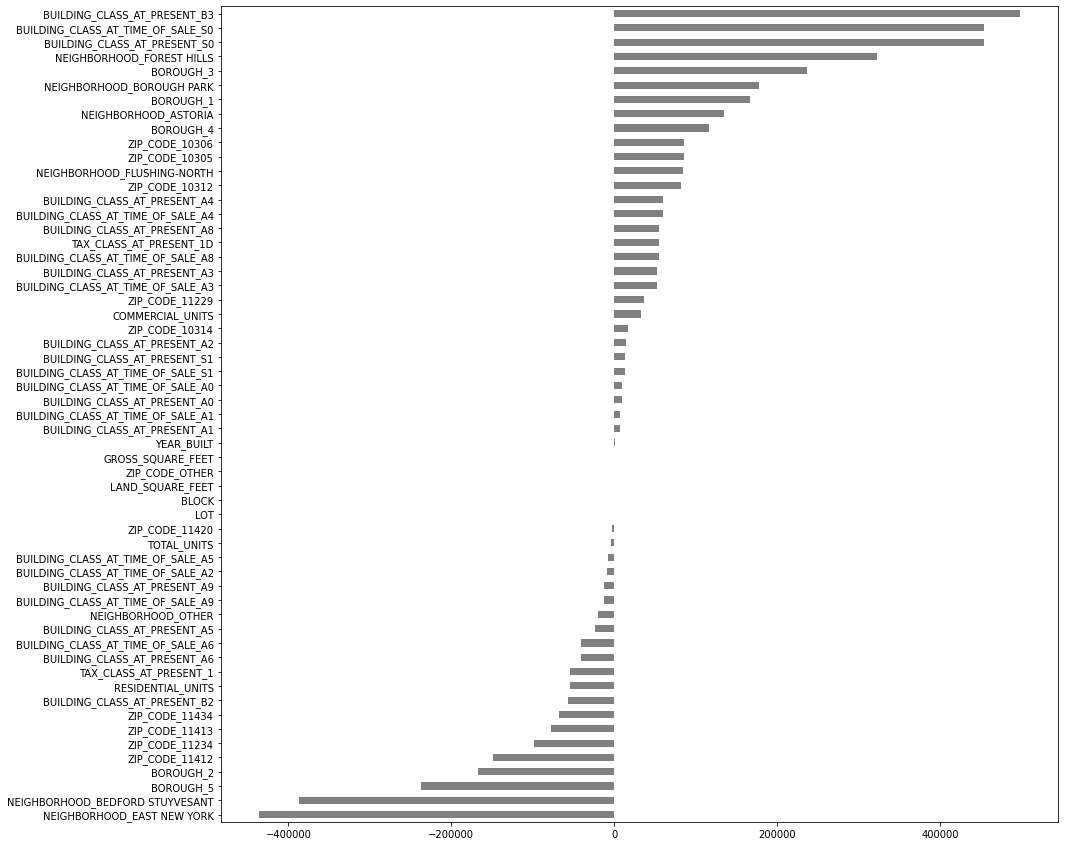

In [246]:
coefficients = model_ridge.coef_
feature_names = XT_train.columns

feature_importances = pd.Series(coefficients, index=feature_names).sort_values(key=abs).tail(15)

display(feature_importances)
# plt.figure(figsize=(16,8))
#     coefficients.sort_values().plot.barh(color='grey')
#     plt.xlim(-400,700)
#     plt.show()

plt.figure(figsize=(15,15))
#feature_importances.plot(kind='barh', color='grey')
pd.Series(coefficients, index=feature_names).sort_values().plot(kind='barh', color='grey')
plt.show()

In [249]:
# RidgeCV model - built in cross-validation

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

model_rcv = RidgeCV(alphas=alphas, normalize=True)
model_rcv.fit(XT_train, y_train)

mae = mean_absolute_error(y_test, model_rcv.predict(XT_test))
rmse = mean_squared_error(y_test, model_rcv.predict(XT_test), squared=False)
r2 = r2_score(y_test, model_rcv.predict(XT_test))

print('For alpha level:', model_rcv.alpha_)
print(f'Test MAE: {mae:,.2f}')
print(f'Test RMSE: {rmse:,.2f}')
print(f'R-squared score: {r2:.2f}')

For alpha level: 0.01
Test MAE: 153,113.63
Test RMSE: 223,172.26
R-squared score: 0.43
